# Prétraitement des données de tweets

Ce notebook prétraite les données de tweets en utilisant les fonctions définies dans le fichier `preprocessing.py`.

Nous préparons nos données au machine learning (nettoyage, vectorisation)

## 1 - Importations des librairies

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sys

# Ajouter le chemin du dossier src pour importer les modules
sys.path.append('../src')
from preprocessing import *
from clean_tweet import *

## 2. Chargement des données

In [2]:
#@title 2.1 Chargement des données

# Charger les données du fichier CSV
df = pd.read_csv('../data/raw/training.1600000.processed.noemoticon.csv', encoding='latin-1', header=None)

# Renommer les colonnes
df.columns = ['sentiment', 'id', 'date', 'query', 'user', 'text']

# Afficher les premières lignes du DataFrame
print("Premières lignes du DataFrame :")
display(df.head())

Premières lignes du DataFrame :


,sentiment,id,date,query,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


## 3. Échantillonage des données

In [3]:

# Mélanger les données
df = df.sample(frac=1)

# Échantillonner 10 % des données
df = df.sample(frac=0.1)

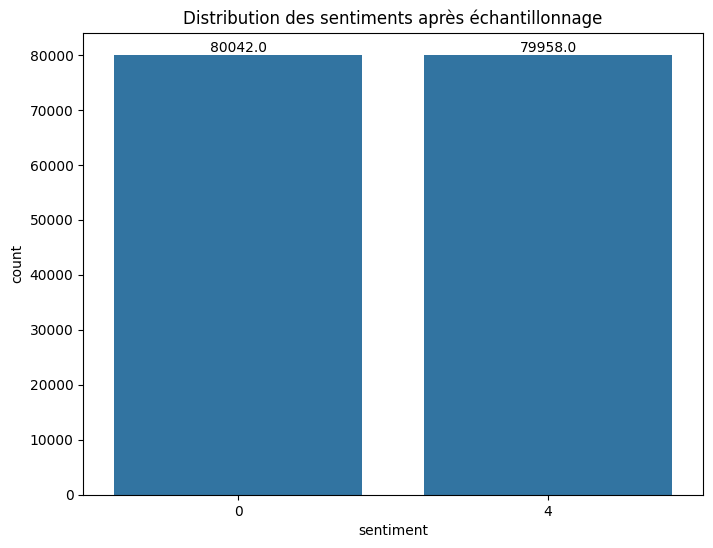

In [4]:
# Afficher la distribution des sentiments après l'échantillonnage
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='sentiment', data=df)

# Ajouter les annotations sur les barres
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.title('Distribution des sentiments après échantillonnage')
plt.show()


Après sampling, les classes restent bien équilibrées entre sentiment 4 (positif) et sentiment 0 (négatif)

## 4. Prétraitement des données

### 4.1 - Nettoyage du texte

In [5]:
#@title 3.1 Nettoyage du texte

# Appliquer la fonction de nettoyage du module preprocessing
df['text'] = df['text'].map(lambda tweet: clean_tweet(tweet))

# Afficher les premières lignes du DataFrame avec les tweets nettoyés
print("Premières lignes du DataFrame avec les tweets nettoyés :")
display(df.head())

Premières lignes du DataFrame avec les tweets nettoyés :


,sentiment,id,date,query,user,text
75592,0,1695242707,Mon May 04 05:37:23 PDT 2009,NO_QUERY,skyducker,eh long weekend made two color viny banner pla...
420466,0,2062214606,Sat Jun 06 22:37:21 PDT 2009,NO_QUERY,lexxxthesex,hahaha wont sleeping day
1086059,4,1969266009,Fri May 29 23:30:17 PDT 2009,NO_QUERY,meghangillies,sleeping janices
977716,4,1833764522,Mon May 18 00:22:39 PDT 2009,NO_QUERY,phatrisha,currently watching paano ba ang mangarap
1032739,4,1933235680,Tue May 26 23:21:19 PDT 2009,NO_QUERY,jmleonoras,say chore mode sing along woot isang kaadikang...


### 4.2 - Conversion des labels en 0 et 1

In [6]:
#@title Conversion des labels en 0 et 1

df['sentiment'] = df['sentiment'].map({0: 0, 4: 1})  # Convertir les labels en 0 et 1

### 4.3 - Vectorisation

In [7]:
#@title 3.3 Vectorisation

from sklearn.model_selection import train_test_split

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(df['text'], 
                                                    df['sentiment'], 
                                                    stratify = df["sentiment"],
                                                    test_size=0.2)

# Vectorisation TF-IDF
X_train_tfidf, X_test_tfidf = vectorize_tfidf(X_train, X_test)

# Vectorisation Word2Vec
X_train_w2v, X_test_w2v = vectorize_word2vec(X_train, X_test)

# Vectorisation Doc2Vec
X_train_d2v, X_test_d2v = vectorize_doc2vec(X_train, X_test)

### 4.4 - Réduction de dimensionnalité

In [8]:
#@title 3.4 Réduction de dimensionnalité

# Réduction de dimensionnalité pour TF-IDF
X_train_tfidf, X_test_tfidf = reduce_dimensionality(X_train_tfidf, 
                                                    X_test_tfidf,
                                                    y_train,
                                                    k=500,
                                                    nom="tfidf")

# Réduction de dimensionnalité pour Word2Vec
X_train_w2v, X_test_w2v = reduce_dimensionality(X_train_w2v,
                                                X_test_w2v,
                                                y_train,
                                                k=500,
                                                nom="word2vec")

# Réduction de dimensionnalité pour Doc2Vec
X_train_d2v, X_test_d2v = reduce_dimensionality(X_train_d2v,
                                                X_test_d2v,
                                                y_train,
                                                k=500,
                                                nom="doc2vec")

## 5. Sauvegarde des données prétraitées

In [9]:
#@title 4.1 Sauvegarde des données

import os
import pickle 

# Chemin d'accès au dossier data
data_path = '../data/processed/'

# Créer le dossier s'il n'existe pas
os.makedirs(data_path, exist_ok=True)


# Sauvegarde des données X_train, y_train non vectorisées

with open(data_path + f'X_train.pickle', 'wb') as f:
    pickle.dump(X_train, f)
with open(data_path + f'X_test.pickle', 'wb') as f:
    pickle.dump(X_test, f)

# Sauvegarde des données pour chaque méthode
def save_data(X_train, X_test, methode):
    with open(data_path + f'X_train_{methode}.pickle', 'wb') as f:
        pickle.dump(X_train, f)
    with open(data_path + f'X_test_{methode}.pickle', 'wb') as f:
        pickle.dump(X_test, f)

save_data(X_train_tfidf, X_test_tfidf, "tfidf")
save_data(X_train_w2v, X_test_w2v, "word2vec")
save_data(X_train_d2v, X_test_d2v, "doc2vec")

# Sauvegarde de y_train et y_test
with open(data_path + 'y_train.pickle', 'wb') as f:
    pickle.dump(y_train, f)

with open(data_path + 'y_test.pickle', 'wb') as f:
    pickle.dump(y_test, f)